In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="medicinemodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
medicineFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
medicineFOSID = medicineFOSID.filter(medicineFOSID["Domain"]=="Medicine").collect()

In [8]:
len(medicineFOSID)

299

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(medicineFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+--------+
|   FOS_ID|  Domain|
+---------+--------+
|199343813|Medicine|
|187212893|Medicine|
+---------+--------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

11531494

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [19]:
(sample1,sample2) = papers_filtered1.randomSplit([0.1,0.5])

In [20]:
sample1.count()

1922056

In [21]:
from sklearn import model_selection
from sklearn.model_selection import KFold 

In [22]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             2|
|             1|
|             0|
|             0|
+--------------+
only showing top 4 rows



In [23]:
sample1_pd = sample1.toPandas()

In [24]:
import numpy as np

In [25]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [26]:
from sklearn import metrics

In [27]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 3.5604144728353386)
('Mean Squared Error of EstimatedCount:', 1148.5091422934609)
('Root Mean Squared of with EstimatedCount:', 33.889661289152194)


In [28]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [29]:
sample1_pd.shape

(1922056, 12)

In [30]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [31]:
from sklearn.model_selection import KFold

In [32]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 2.8379572716423973)
('Mean Squared Error:', 353.59704681951644)
('Root Mean Squared Error:', 18.804176313242664)
('Mean Absolute Error:', 4.26852731014089)
('Mean Squared Error:', 282.85702174530195)
('Root Mean Squared Error:', 16.81835371685653)
('Mean Absolute Error:', 3.241035232433357)
('Mean Squared Error:', 634.8368778859685)
('Root Mean Squared Error:', 25.19596947700105)
('Mean Absolute Error:', 2.3782445723452996)
('Mean Squared Error:', 805.6647644128345)
('Root Mean Squared Error:', 28.384234434150844)
('Mean Absolute Error:', 2.6516855492470905)
('Mean Squared Error:', 159.57721206532383)
('Root Mean Squared Error:', 12.632387425396825)


In [35]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 20.367024273329584)


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
featureslist=sample1_pd.columns

In [38]:
importances = regressor.feature_importances_

In [39]:
import pandas as pd

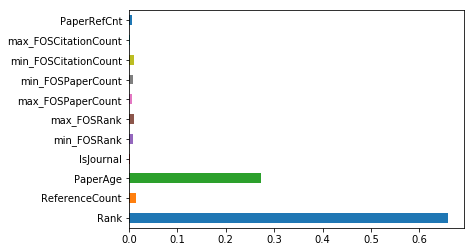

In [40]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

## XGBoost Regression model

In [41]:
import xgboost as xgb

In [42]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [43]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 384412,  384413,  384414, ..., 1922053, 1922054, 1922055]), 'TEST:', array([     0,      1,      2, ..., 384409, 384410, 384411]))
('Mean Absolute Error of XGBoost Kfold:', 2.8302964052538377)
('Mean Squared Error of XGBoost Kfold:', 344.44760731142514)
('Root Mean Squared Error of XGBoost Kfold:', 18.55929975272303)
('TRAIN:', array([      0,       1,       2, ..., 1922053, 1922054, 1922055]), 'TEST:', array([384412, 384413, 384414, ..., 768820, 768821, 768822]))
('Mean Absolute Error of XGBoost Kfold:', 4.4498720651769785)
('Mean Squared Error of XGBoost Kfold:', 324.7342863739137)
('Root Mean Squared Error of XGBoost Kfold:', 18.0203853003734)
('TRAIN:', array([      0,       1,       2, ..., 1922053, 1922054, 1922055]), 'TEST:', array([ 768823,  768824,  768825, ..., 1153231, 1153232, 1153233]))
('Mean Absolute Error of XGBoost Kfold:', 3.3298184647940836)
('Mean Squared Error of XGBoost Kfold:', 386.06087420187976)
('Root Mean Squared Error of XGBoost Kfold:', 1

In [44]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 19.48982529120206)


In [45]:
importances = regressor.feature_importances_

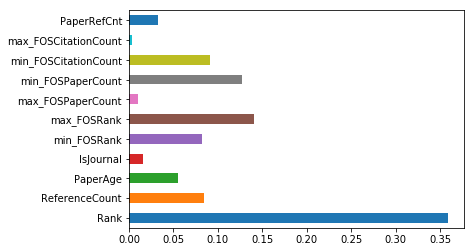

In [46]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [47]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.35851
Feature: 1, Score: 0.08400
Feature: 2, Score: 0.05524
Feature: 3, Score: 0.01565
Feature: 4, Score: 0.08207
Feature: 5, Score: 0.14023
Feature: 6, Score: 0.00970
Feature: 7, Score: 0.12764
Feature: 8, Score: 0.09166
Feature: 9, Score: 0.00309
Feature: 10, Score: 0.03220


In [19]:
drop_cols = ["FOS_ID","PaperID","EstimatedCount","Domain","PaperYear","Volume","Issue"]
papers_filtered = papers_filtered.drop(*drop_cols)

In [20]:
papers_filtered1 = papers_filtered.select(["Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [29]:
(sample1, sample2,sample3)=papers_filtered1.randomSplit([0.1,0.2,0.7])

In [30]:
from sklearn import model_selection
from sklearn.model_selection import KFold

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
len(sample1.columns)

12

In [33]:
papers_pd = sample1.toPandas()

In [34]:
papers_pd.shape

(1152352, 12)

In [35]:
X = papers_pd.iloc[:, 0:11].values
y = papers_pd.iloc[:, 11].values

In [36]:
y[0:5]

array([1085, 1013,  185,  490,  187], dtype=int32)

In [37]:
y.max()

10627

In [39]:
kfold = model_selection.KFold(n_splits=5, random_state=10)
model = RandomForestRegressor(n_estimators= 1000,max_depth=3)

In [40]:

results = model_selection.cross_val_score(model, X, y, cv=kfold,scoring="neg_mean_absolute_error")


In [41]:
print("Neg Mean Abosulte error: %.3f%% " % (results.mean()))

Neg Mean Abosulte error: -8.367% 


In [42]:
y.std()

49.42112267226819